In [ ]:
"""import os 
df="/kaggle/working/"
os.makedirs(df+"images")
os.makedirs(df+"dcimages")"""

In [1]:
"""from google.colab import drive
drive.mount('/content/drive')"""

Mounted at /content/drive


Libraries


In [2]:
import os
import time
import shutil
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
import sys
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

import warnings

Definitions for InceptionV3 and FID Score

In [19]:
INCEPTION_SHAPE=(299, 299, 3)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)

def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)

    return np.asarray(images_list)

def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid



In [4]:
def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [9]:
"""def calculate_is(images, n_split=10, eps=1E-16):
 # load inception v3 model
    model = inception
    # convert from uint8 to float32
    processed = images.astype('float32')
    # pre-process raw images for inception v3 model
    processed = preprocess_input(processed)
    # predict class probabilities for images
    yhat = model.predict(processed)
    # enumerate splits of images/predictions
    scores = list()
    n_part = np.floor(images.shape[0] / n_split)
    for i in range(n_split):
    # retrieve p(y|x)
        ix_start, ix_end = int(i * n_part), int(i * n_part + n_part)
        p_yx = yhat[ix_start:ix_end]
        # calculate p(y)
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = np.mean(sum_kl_d)
        # undo the log
        is_score = np.exp(avg_kl_d)
        # store
        scores.append(is_score)
        # average across images
        is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std"""

Evaluating trained model

In [6]:
(_,_),(X_test,_)=mnist.load_data()
gan=keras.models.load_model("model/gen")
GAN_images=gan.predict(generate_latent_samples(1000, 100))


11490434/11490434 [==============================] - 0s 0us/step


32/32 [==============================] - 0s 5ms/step


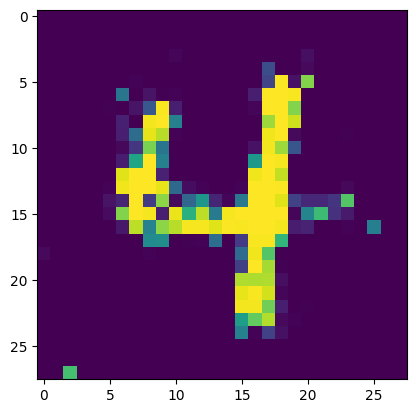

In [8]:
plt.imshow(GAN_images[5])

FID SCORE

In [10]:
new_GAN_imgs=scale_images(GAN_images,(299,299,3))

32/32 [==============================] - 0s 5ms/step


In [11]:
X_test_batch = X_test[np.random.choice(len(X_test), 1000, replace=True), :]
X_test_batch = scale_images(X_test_batch,(299,299,3))
FID = calculate_fid(inception, X_test_batch, new_GAN_imgs)
#ıs,_=calculate_is(new_GAN_imgs,10,eps=1E-16)
print("FID: ",format(FID))
#print("IS: ",format(ıs))

32/32 [==============================] - 221s 7s/step
FID:  125.9296976202719
IS:  1072340800.0


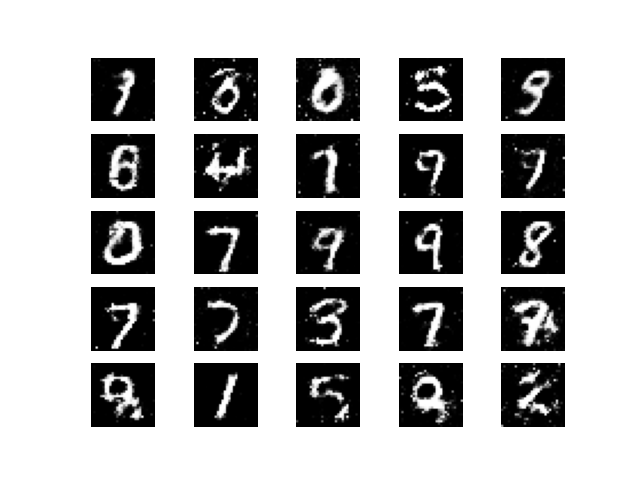

In [4]:
from PIL import Image

son_epoch=Image.open("images/10000.png")
son_epoch